# Data Cleaning


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
from scipy import signal

from data_processing.config import BOOT_LABEL_FILE, POLE_LABEL_FILE
from data_processing.labels_util import get_labels_data, LabelCol
from data_processing.imu_util import list_imu_abspaths, ImuCol, load_imu_data, Sensor, to_row_range
from data_processing.enums import Activity

# import data types
from pandas import DataFrame
from numpy import ndarray

## Checking Validity of Data
Check the timestamps of all IMU data files. Make sure the skate/pole labels files are referring to the right timestamps/tests.

In [3]:
# Experiment time! Check the min and max date ranges of all 
max_epoch = None
min_epoch = None

for filepath in list_imu_abspaths(sensor_type=Sensor.Accelerometer):
    imudata = load_imu_data(filepath)
    curr_max = imudata[:, ImuCol.TIME].max()
    curr_min = imudata[:, ImuCol.TIME].min()

    print(filepath)
    print(curr_min, curr_max)

    if max_epoch is None:
        max_epoch = curr_max
    else:
        max_epoch = max(max_epoch, curr_max)

    if min_epoch is None:
        min_epoch = curr_min
    else:
        min_epoch = min(min_epoch, curr_min)

print('Min/max of all files:', min_epoch, max_epoch)

/home/multiw/Nimble-Innovations/app/model/data/data/11L_2020-08-13T09.48.23.554_E8E376103A59_Accelerometer.csv
1597206834085.0 1602958697177.0
/home/multiw/Nimble-Innovations/app/model/data/data/11R_2020-10-17T09.50.55.227_C38EC55152D6_Accelerometer.csv
1602953455227.0 1602954727533.0
Min/max of all files: 1597206834085.0 1602958697177.0


## Mapping labelled ski steps to IMU data
Try it on one ski test to make flush out potential issues and check that it's doable.

[145]
Sensor name: 11L
Start time: 1597337537142
End time: 1597337722672
Start row: 11779
End row: 21414
[[ 1.59733754e+12  5.65000000e-01  5.40000000e-02  8.29000000e-01]
 [ 1.59733754e+12  6.00000000e-01  2.40000000e-02  8.14000000e-01]
 [ 1.59733754e+12  6.02000000e-01  4.00000000e-03  8.09000000e-01]
 ...
 [ 1.59733772e+12  7.37000000e-01  3.30000000e-02  1.07500000e+00]
 [ 1.59733772e+12  4.73000000e-01 -3.00000000e-03  8.57000000e-01]
 [ 1.59733772e+12  9.84000000e-01  3.12000000e-01  6.55000000e-01]]
(9636, 4)


<IPython.core.display.Javascript object>


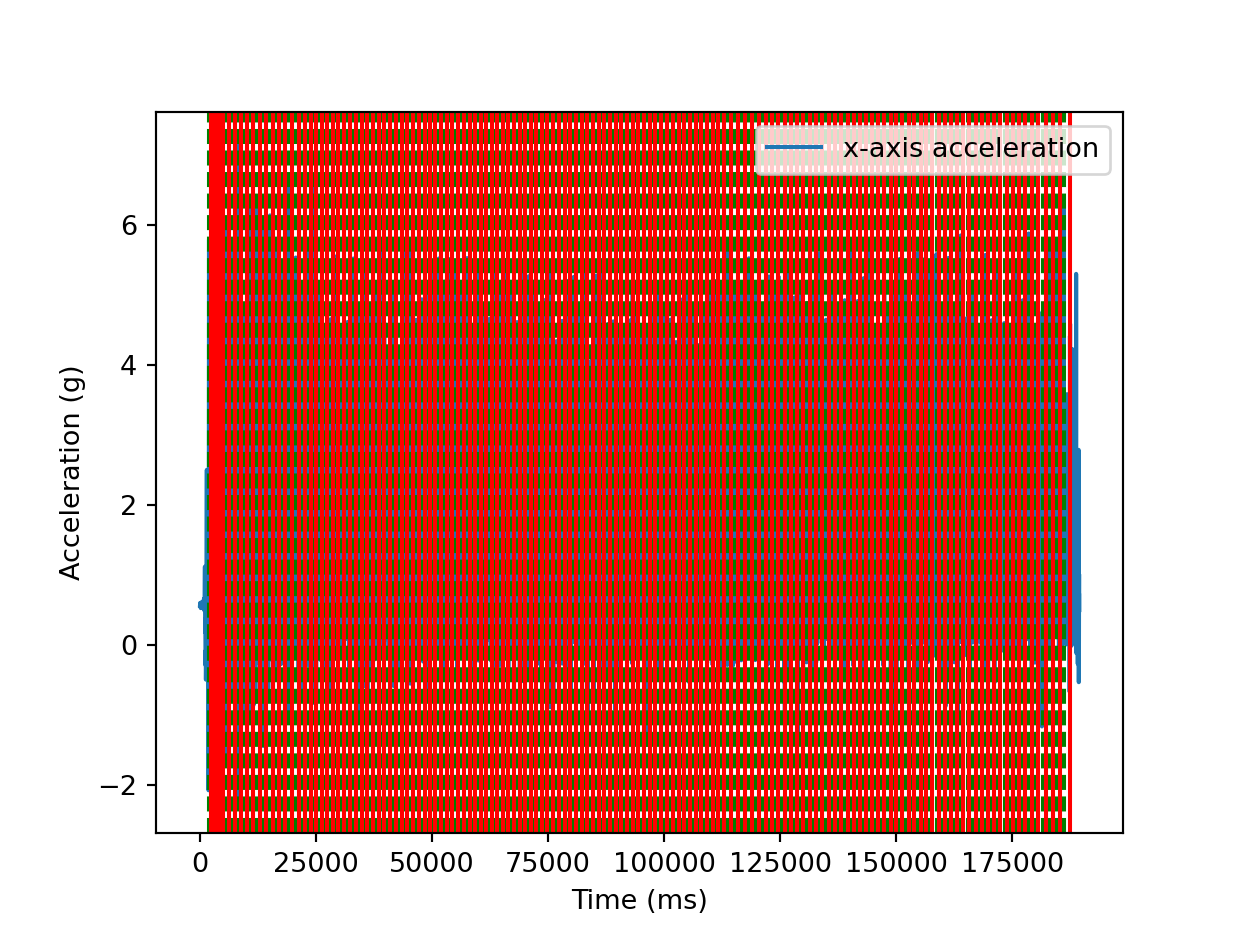

In [4]:
# Load labels data
labels: ndarray = get_labels_data(BOOT_LABEL_FILE, Activity.Boot)
#labels: ndarray = get_labels_data(POLE_LABEL_FILE, Activity.Pole)

# Get starts of all ski tests
time_diff = np.diff(labels[:, LabelCol.TIME])
end_indices = np.where(time_diff < 0)[0] # row numbers

print(end_indices)

# Get first available ski test labels
# NOTE: it's possible that a ski test points to a non-existent IMU file or points to a non-existent timestamp within the file
# TODO: something is fishy... most ski tests don't map to the raw IMU data
imu_data = None
test_labels = None
num_tests = len(end_indices) + 1
for i in range(num_tests):
    # Get labels for test i
    sensor_name = None
    start_time = None
    end_time = None
    
    if i == 0: # first test
        test_labels = labels[:end_indices[0]+1, :]
    elif i == num_tests-1: # last test
        test_labels = labels[end_indices[-1]+1:, :]
    else:
        test_labels = labels[end_indices[i-1]+1:end_indices[i]+1, :]

    sensor_name = test_labels[0, LabelCol.SENSOR]
    start_time = test_labels[0, LabelCol.START]
    end_time = test_labels[-1, LabelCol.END]

    print('Sensor name:', sensor_name)
    print('Start time:', start_time)
    print('End time:', end_time)

    # Load IMU data file
    imu_files = list_imu_abspaths(sensor_name=sensor_name, sensor_type=Sensor.Accelerometer)
    if len(imu_files) == 0:
        print('WARNING: No file found for sensor: %s. Skipping...' % sensor_name)
        continue
    imu_data = load_imu_data(imu_files[0])
    
    start_row, end_row = to_row_range(imu_data, start_time, end_time, expected_range=3*60, expected_range_error=10)
    if start_row is None or end_row is None:
        print('WARNING: Cannot map label to IMU data. Skipping...')
        continue
    
    start_row = max(0, start_row - 100)
    end_row = min(imu_data.shape[0] - 1, end_row + 100)
    
    print('Start row:', start_row)
    print('End row:', end_row)
        
    imu_data = imu_data[start_row:end_row+1,:]
    if imu_data.shape[0] == 0:
        print('WARNING: No IMU data found between timestamps %d and %d. Skipping' % (start_time, end_time))
        continue
        
    print(imu_data)
    print(imu_data.shape)
        
    # Use first valid test
    break

# Graph results
first_timestamp = imu_data[0, ImuCol.TIME]
pyplot.plot(imu_data[:, ImuCol.TIME] - first_timestamp, imu_data[:, ImuCol.XACCEL], label = "x-axis acceleration")
pyplot.xlabel('Time (ms)')
pyplot.ylabel('Acceleration (g)')

for i in range(test_labels.shape[0]):
    # plot step start
    pyplot.axvline(x=test_labels[i, LabelCol.START] - first_timestamp, linestyle='dashed', color='green')
    
for i in range(test_labels.shape[0]):
    # plot step end
    pyplot.axvline(x=test_labels[i, LabelCol.END] - first_timestamp, linestyle='solid', color='red')

pyplot.rcParams['figure.figsize'] = [9, 5]
pyplot.legend()
pyplot.show()